# A Gentle (Mathematicians) Introduction to PyTorch and Neural Networks Part 03
#### Todo: Change intro
In this blog posts, I'd like to introduce a commonly used optimizer for training models such as the logistic model we introduced in the [last post](https://linus-lach.de/posts/post-with-code/pytorch/post_01).

The structure of this post is as follows:
First, we familiarize ourselves a bit with the `PyTorch` framework. To build on this newly gained knowledge, we build a logistic model with `PyTorch` and gain some understanding about the binary cross-entropy loss in a theoretical setting.
In the final part we will learn how to train our logistic regression model to achieve a good fit on given data.

## (Stochastic) gradient descent

In [2]:
#Some packages needed throughout the article
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
%matplotlib inline


## Gradient descent in two dimensions

In [9]:
def train_model_GD(iter,lr,f,x1,x2):
    COORD = []
    for epoch in range(iter):
        loss = f(x1,x2)
        COORD.append([x1.data,x2.data,loss.data])
        loss.backward()
        x1.data = x1.data - lr * x1.grad.data
        x2.data = x2.data - lr * x2.grad.data

        x1.grad.data.zero_();x2.grad.data.zero_()

    return np.transpose(np.reshape(COORD,(iter,3)))

In [10]:
def f_(x,y):
    return 2*(2-x)**2*(torch.exp(-1*(x**2)-(y+1)**2))-15*(1/5*x-x**3-y**3)*torch.exp(-x**2 - y**2)-1/3*torch.exp(-(x + 1)**2 - y**2)

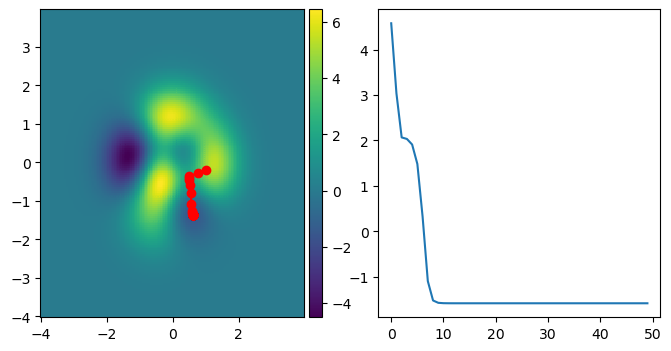

In [11]:
X = torch.arange(-4,4,0.05)
Y = torch.arange(-4,4,0.05)
XX,YY = torch.meshgrid(X,Y,indexing='ij')
ZZ = f_(XX,YY)

n = 50
lr = 0.05
x1 = torch.tensor(1.0, requires_grad=True)
x2 = torch.tensor(-0.2, requires_grad=True)
COORD = train_model_GD(n, lr, f_, x1, x2)

fig = plt.figure(figsize = (8,4))

ax1 = fig.add_subplot(121)

im1 = ax1.pcolor(XX, YY, ZZ)
im2 = ax1.plot(COORD[0], COORD[1], 'o-r')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
im3 = ax2.plot(COORD[2])

In [12]:
x1 = torch.tensor(1.0, requires_grad=True)
x2 = torch.tensor(-0.2, requires_grad=True)

In [13]:
LOSS = []
tmp = f_(x1,x2)
LOSS.append([x1,x2,tmp])

In [14]:
def lr_grid(grid):
    res = []
    for elem in grid:
       x1 = torch.tensor(1.0, requires_grad=True)
       x2 = torch.tensor(-0.2, requires_grad=True)
       res.append(train_model_GD(n,elem,f_,x1,x2)[2][-1])
    return res

In [15]:
grid = np.arange(0.01,0.5,0.01)
tmp = lr_grid(grid)

0.04 -1.5846603


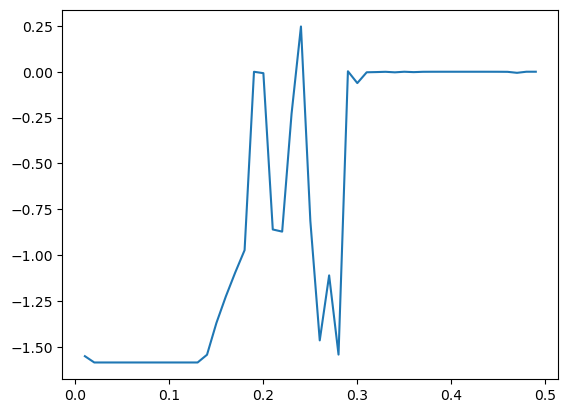

In [16]:
print(grid[np.argmin(tmp)], min(tmp))
plt.plot(grid,tmp)

### Grid search initial values

In [17]:
def iv_grid(n):
    RES = []
    for j in range(-2*n,2*n+1,2):
        for i in range(-2*n,2*n+1,2):
          RES.append(train_model_GD(20,0.1,f_,torch.tensor(i/n,requires_grad=True),torch.tensor(j/n,requires_grad=True)))
    return RES

In [18]:
n=1
tmp = iv_grid(n)

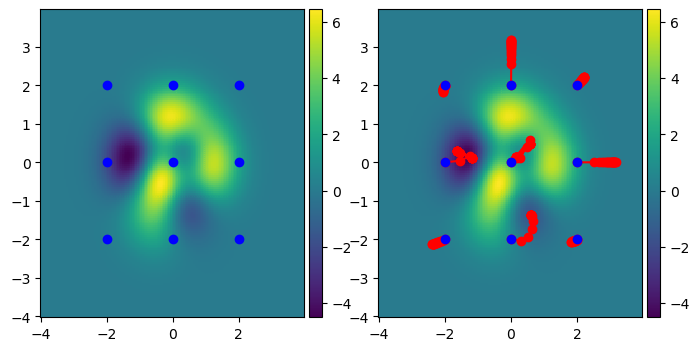

In [19]:
fig = plt.figure(figsize = (8,4))

ax1 = fig.add_subplot(121)
im1 = ax1.pcolor(XX, YY, ZZ)
for i in range(np.shape(tmp)[0]):
    im2 = ax1.plot(tmp[i][0][0], tmp[i][1][0], 'o-b')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
im3 = ax2.pcolor(XX, YY, ZZ)
for i in range(np.shape(tmp)[0]):
    im4 = ax2.plot(tmp[i][0], tmp[i][1], 'o-r')
    im5 = ax2.plot(tmp[i][0][0], tmp[i][1][0], 'o-b')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical');


## Stochastic gradient descent in two dimensions
### Gradient descent for logistic regression

In [20]:
# Create a dataset class that produces our example data

class Data_2(Dataset):

    def __init__(self, soft_max=False,n = 40):
        step = 4/n
        self.x = torch.arange(-2, 2, step = step).view(-1, 1)
        if soft_max:
            self.y = torch.zeros(self.x.shape[0])
        else:
            self.y = torch.zeros(self.x.shape[0], 1)
        self.y[self.x[:, 0] > 0.5] = 1
        if soft_max:
            self.y = self.y.type(torch.LongTensor)
        self.len = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

def plot_data_2(data, model = None, est_line=False, soft_max=False):
    if est_line:
        plt.plot(data.x,
                 torch.sigmoid(list(model.parameters())[0].item() * data.x + list(model.parameters())[1].item()),
                 color='black',
                 label='estimated decision boundary')
    if soft_max:
        X = data[:][0]
        y_label = ['yhat=0', 'yhat=1']
        y_color = ['r', 'b']
        Y = []
        for w, b, y_l, y_c in zip(model.state_dict()['0.weight'], model.state_dict()['0.bias'], y_label, y_color):
            Y.append((w * X + b).numpy())
            plt.plot(X.numpy(), (w * X + b).numpy(), y_c, label=y_l)
    plt.plot(data.x.numpy()[(data.y == 0)], data.y.numpy()[(data.y == 0)], 'ro', label="class 0")
    plt.plot(data.x.numpy()[(data.y == 1)], data.y.numpy()[(data.y == 1)], 'bo', label="class 1")
    plt.legend()
    plt.ylim(-0.5, 3)
    plt.show()

In [21]:
W = torch.arange(-10,30,0.2)
B = torch.arange(-20,5,0.2)

WW,BB = torch.meshgrid(W,B,indexing = 'ij')

In [22]:
data_2 = Data_2(n=60)
loss = nn.MSELoss()

def wb_loss(w,b):
    yhat = torch.sigmoid(data_2.x*w+b)
    return loss(yhat,data_2.y)

In [23]:
count_j = 0
ZZ = torch.zeros_like(WW)
for w0,b0 in zip(WW,BB):
    count_i = 0
    for w1,b1 in zip(w0,b0):
        ZZ[count_j,count_i] = wb_loss(w1,b1).detach()
        count_i += 1
    count_j += 1

In [24]:
w0 = torch.tensor(-8.0,requires_grad=True)
b0 = torch.tensor(3.0,requires_grad=True)


In [25]:
coord = train_model_GD(450,20,wb_loss,w0,b0)

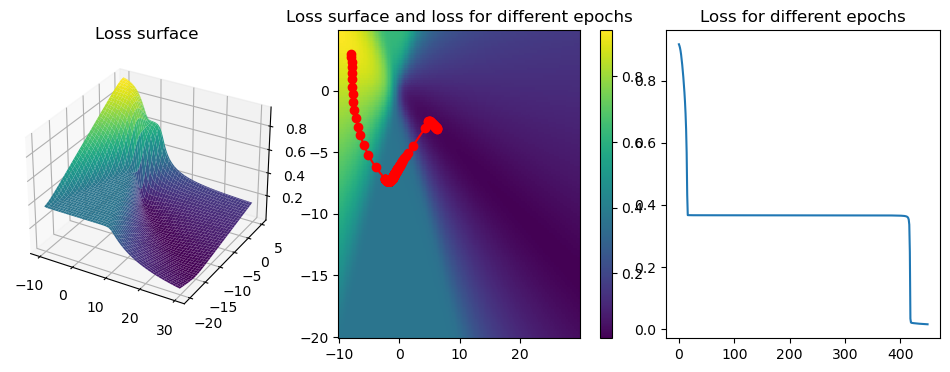

In [26]:
fig = plt.figure(figsize= (12,4))

ax1 = fig.add_subplot(131, projection = '3d')
im1 = ax1.plot_surface(WW,BB,ZZ, cmap = 'viridis')
ax1.set_title('Loss surface')

ax2 = fig.add_subplot(132)
im2 = ax2.pcolor(WW,BB,ZZ)
im3 = ax2.plot(coord[0],coord[1],'-or')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(im2, cax=cax, orientation='vertical')
ax2.set_title('Loss surface and loss for different epochs')
#
ax3 = fig.add_subplot(133)
im4 = ax3.plot(coord[2])
ax3.set_title('Loss for different epochs');

### Stochastic gradient descent full batch

In [30]:
def forward(x,w,b):
    return torch.sigmoid(x*w+b)

def train_model_SGD(epochs, lr, w,b, plot_coords = False):
    COORD = []
    LOSS = []
    loss = nn.MSELoss()
    if plot_coords:
        col = ['blue' if i%2==0 else 'red' for i in range(epochs)]
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        im1 = ax1.pcolor(WW,BB,ZZ)

    for epoch in range(epochs):
        yhat = forward(data_2.x,w,b)
        LOSS.append(loss(yhat,data_2.y).data)
        COORD.append([w.data,b.data])
        for x,y in zip(data_2.x,data_2.y):
            yhat = forward(x,w,b)
            l = loss(yhat,y)
            l.backward()
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data
            w.grad.data.zero_();b.grad.data.zero_()

        if plot_coords:
            im2 = ax1.plot(np.transpose(np.reshape(COORD,(-1,2)))[0],np.transpose(np.reshape(COORD,(-1,2)))[1], '-or')
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes('right', size='5%', pad=0.2)
            fig.colorbar(im1, cax=cax, orientation='vertical')
            ax1.set_title('Loss surface and loss for different epochs')

    return LOSS, np.transpose(np.reshape(COORD,(-1,2)))


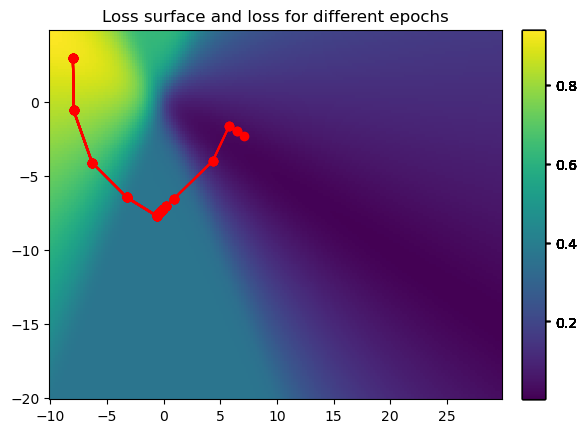

In [38]:
w0 = torch.tensor(-8.0,requires_grad=True)
b0 = torch.tensor(3.0,requires_grad=True)
loss_sgd, coord = train_model_SGD(17,5,w0,b0,True)

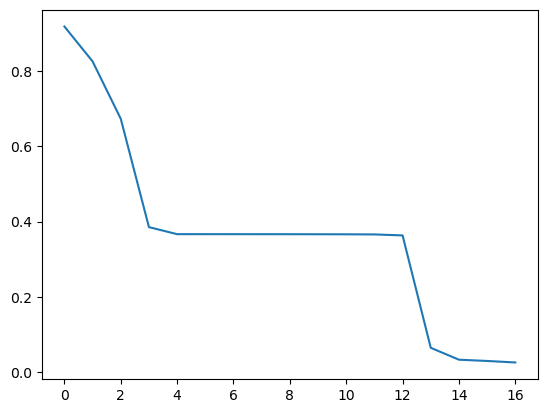

In [39]:
plt.plot(loss_sgd)

In [41]:
%%timeit
train_model_SGD(17,5,w0,b0)

150 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Stochastic gradient descent custom batch

In [42]:
def customdataloader(data, batch_size, shuffle = False):
    if shuffle:
        idx = torch.randperm(data_2.x.nelement())
        data.x = data.x.view(-1)[idx].view(data_2.len)
        data.y = data.y.view(-1)[idx].view(data_2.len)
    data = [[data.x[i:i + batch_size],data.y[i:i+batch_size]] for i in range(0, len(data), batch_size)]

    return data

def train_model_SGD_tl(epochs, lr, w,b,trainloader, plot_coords = False):
    COORD = []
    LOSS = []
    loss = nn.MSELoss()
    if plot_coords:
        col = ['blue' if i%2==0 else 'red' for i in range(epochs)]
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        im1 = ax1.pcolor(WW,BB,ZZ)

    for epoch in range(epochs):
        yhat = forward(data_2.x,w,b)
        LOSS.append(loss(yhat,data_2.y).data)
        COORD.append([w.data,b.data])
        for x,y in trainloader:
            yhat = forward(x,w,b)
            l = loss(yhat,y)
            l.backward()
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data
            w.grad.data.zero_();b.grad.data.zero_()

    if plot_coords:
        im2 = ax1.plot(np.transpose(np.reshape(COORD,(-1,2)))[0],np.transpose(np.reshape(COORD,(-1,2)))[1], '-or')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.2)
        fig.colorbar(im1, cax=cax, orientation='vertical')
        ax1.set_title('Loss surface and loss for different epochs')

    return LOSS, np.transpose(np.reshape(COORD,(-1,2)))


In [67]:
w0 = torch.tensor(-8.0,requires_grad=True)
b0 = torch.tensor(3.0,requires_grad=True)
#trainloader = DataLoader(dataset=data_2, batch_size=4,shuffle=True)
trainloader = customdataloader(data = data_2,batch_size=2, shuffle= True)
loss_sgd, coord  = train_model_SGD_tl(45,5,w0,b0,trainloader)


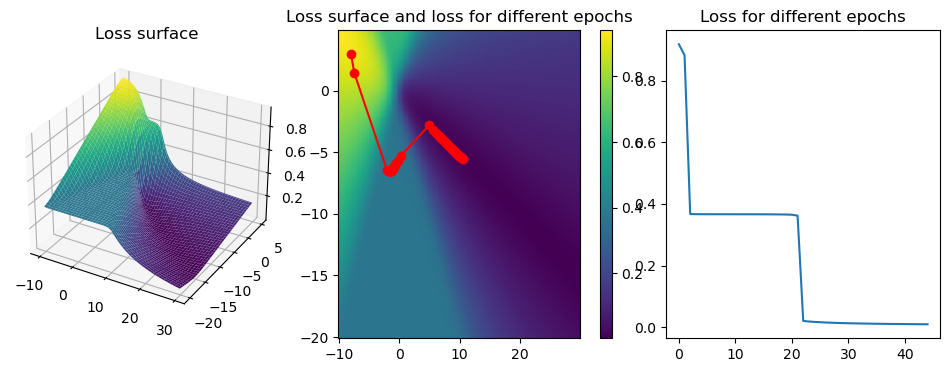

In [68]:
fig = plt.figure(figsize= (12,4))

ax1 = fig.add_subplot(131, projection = '3d')
im1 = ax1.plot_surface(WW,BB,ZZ, cmap = 'viridis')
ax1.set_title('Loss surface')

ax2 = fig.add_subplot(132)
im2 = ax2.pcolor(WW,BB,ZZ)
im3 = ax2.plot(coord[0],coord[1],'-or')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(im2, cax=cax, orientation='vertical')
ax2.set_title('Loss surface and loss for different epochs')
#
ax3 = fig.add_subplot(133)
im4 = ax3.plot(loss_sgd)
ax3.set_title('Loss for different epochs');

In [69]:
%%timeit
loss_sgd, coord  = train_model_SGD_tl(45,5,w0,b0,trainloader)

209 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## ADAM in two dimensions


In [78]:
def train_model_adam(epochs, w,b, trainloader, lr=0.001, plot_coords = False, beta1=0.9, beta2=0.999, eps=1e-8):

    mw = torch.tensor(0.0)  # First moment estimate
    vw = torch.tensor(0.0)  # Second moment estimate
    mb = torch.tensor(0.0)  # First moment estimate
    vb = torch.tensor(0.0)  # Second moment estimate

    COORD = []
    LOSS = []
    loss = nn.MSELoss()
    if plot_coords:
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        im1 = ax1.pcolor(WW,BB,ZZ)

    for epoch in range(epochs):
        yhat = forward(data_2.x,w,b)
        LOSS.append(loss(yhat,data_2.y).data)
        for x,y in trainloader:
            """"Start Adam optimizer here"""
            yhat = forward(x,w,b)
            l = loss(yhat,y)
            l.backward()
            mw  = beta1 * mw + (1 - beta1) * w.data
            mb = beta1 * mb + (1 - beta1) * b.data
            vw = beta1 * vw + (1 - beta1) * w.data
            vb = beta1 * vb + (1 - beta1) * b.data

            mw_hat = mw / (1 - beta2 ** epoch)
            mb_hat = mb / (1 - beta2 ** epoch)
            vw_hat = vw / (1 - beta2 ** epoch)
            vb_hat = vb / (1 - beta2 ** epoch)

            w.data -= lr * mw_hat / (np.sqrt(vw_hat) + eps)
            b.data -= lr * mb_hat / (np.sqrt(vb_hat) + eps)
            COORD.append([w.data,b.data])
            w.grad.data.zero_();b.grad.data.zero_()

    if plot_coords:
        im2 = ax1.plot(np.transpose(np.reshape(COORD,(-1,2)))[0],np.transpose(np.reshape(COORD,(-1,2)))[1], '-or')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.2)
        fig.colorbar(im1, cax=cax, orientation='vertical')
        ax1.set_title('Loss surface and loss for different epochs')

    return LOSS, np.transpose(np.reshape(COORD,(-1,2)))

In [7]:
w0 = torch.tensor(-8.0,requires_grad=True)
b0 = torch.tensor(3.0,requires_grad=True)
loss_adam, coord  = train_model_adam(30,w0,b0,trainloader,1)

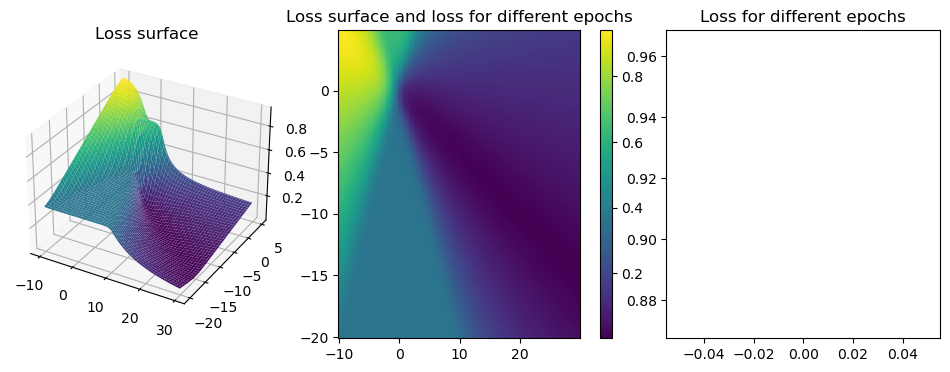

In [80]:
fig = plt.figure(figsize= (12,4))

ax1 = fig.add_subplot(131, projection = '3d')
im1 = ax1.plot_surface(WW,BB,ZZ, cmap = 'viridis')
ax1.set_title('Loss surface')

ax2 = fig.add_subplot(132)
im2 = ax2.pcolor(WW,BB,ZZ)
im3 = ax2.plot(coord[0],coord[1],'-or')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(im2, cax=cax, orientation='vertical')
ax2.set_title('Loss surface and loss for different epochs')
#
ax3 = fig.add_subplot(133)
im4 = ax3.plot(loss_adam)
ax3.set_title('Loss for different epochs');

In [81]:
print(coord[0][:5])

[nan nan nan nan nan]
